## TensorFlow deep NN

### 이 노트북에서는 MNIST 데이터에 TensorFlow library를  적용하는 과정을 살펴봅니다. 

In [2]:
# import
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

In [3]:
# tensorflow 적용해 필요한 hyperparameter 값을 미리 설정한다.

Learning_Rate = 1e-4
Training_iterations = 1000
Dropout = 0.5
Batch_Size = 50
Validation_size = 2000
Image_to_display = 10

In [4]:
# train용 data를 설정해준다.
data = pd.read_csv('../Digit Recognizer/train.csv')

print (data.shape)
print (data.head())

(42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0      

총 42,000개의 행들과 785개의 열로 이루어진 데이터이다. 각 행의 target값은 label colum으로 각 열의 첫 행에 위치한다.
각 행의 값들의 하나의 손글씨 사진에 대한 pixel digit값을 나타낸다. 
총 785개의 열중에서 첫번째 열인 label colum을 제외하면 총 784(28*28)px 형태 임을 알수있다.

In [5]:
images = data.iloc[:,1:].values
images = images.astype(np.float)

images = np.multiply(images, 1.0 / 255.0)

In [6]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# 여기에서는 모든 이미지가 정사각형 형태이다.
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print('image_width => {0}\nimage_height => {1}'.format(image_width, image_height))


image_size => 784
image_width => 28
image_height => 28


image의 output을 살펴보기 위해 1차원 형태의 데이터를 2차원 형태로 바꾸어 보자. 

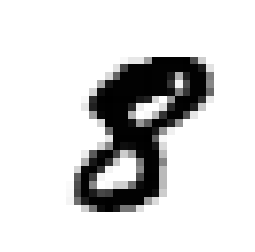

In [7]:
# display image
def display(img):
    # From 784 to 28 * 28 
    one_image = img.reshape(image_width, image_height)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

display(images[Image_to_display])

아라비아 숫자 8로 보이는 형태가 나타난 것을 알수있다. label 값으로 주어진 0~9 사이의 숫자 중 하나가 나타났다.   
이제 이것을 실제 label 값이랑 비교해보자.

In [8]:
labels_flat = data[[0]].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print('labels_flat[{0}] => {1}'.format(Image_to_display, labels_flat[Image_to_display]))

labels_flat(42000)
labels_flat[10] => 8


In [9]:
labels_count = np.unique(labels_flat).shape[0]
print('labels_count => {0}'.format(labels_count))

labels_count => 10


이 data의 label값으로 0~9 까지의 숫자 10개가 고루 있다는 것을 알수있다.

0~9까지의 값은 하나하나의 형태가 scala형태이다. 분류 문제들은 결과값으로 0~9까지의 값이 될 확률을 제시하고 가장 확률이 높은 값을 고르게 하는 경우가 대다수이다. 이 확률 값을 계산하기 위해서는 각각의 label값이 scala로 존재해서는 아니고 10개의 값을 표현 할 수있는 vector의 값으로 존재하여야 한다. 이때 가장 많이 사용되는 것이 'One-Hot-Encoder(vectors)'이다.
여기서는 One-Hot-Encoder를 직접 정의하지만 sklearn에서는 이 기능을 자체적으로 제공한다.

In [10]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
laebls = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print('labels[{0}] => {1}'.format(Image_to_display, labels[Image_to_display]))

labels(42000,10)
labels[10] => [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


이제 전체데이터를 training용과 validation용으로 나누어보자. 

In [11]:
validation_images = images[:Validation_size]
validation_labels = labels[:Validation_size]

train_images = images[Validation_size:]
train_labels = labels[Validation_size:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(40000,784)
validation_images(2000,784)


이제 neural network에 적용하기 위한 단계는 완성되었다.

## TensorFlow graph
TensorFlow에서는 각 operation의 진행과정을 한눈에 파악할수있는 graph를 제공하고 있다. 

### Helper functions(Activation functions)
NN모델에서는 수많은 weights와 bias가 생성된다. 때문에 초기 weights의 설정이 꽤 중요하다고 볼수있다. 또 여기에서는 활성 함수(각 neuron을 통과할때 사용하는 함수)로 ReLU함수를 사용한다. 

In [12]:
# weight의 초기값 설정
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

여기에서는 image recognition에 흔히 사용되는 CNN(Convulution Neural Network)를 사용합니다. Stride/step의 크기는 1로 정해준다.


In [13]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

여기서 max Pooling값은 2x2 blocks이다. 
Pooling은 data를 downsampling하기 위해서 사용된다. 2x2 max-pooling은 2차원 pixel 형태의 block에서 max값만 빼내주는 역할을 한다.

In [14]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

neural network의 좋은 점 어떤 NN이든 layer로 사용될수 있다는 점이다. 이는 어떤 NN의 output은 다른 NN의 input 값이 될 수 있다는 것을 의미한다. 이 NN의 집합이 성능이 좋은  NN을 만들어내고 이것이 Deep Neural Newworks가 된다.

여기에서는 우리는 2개의 Hidden Layers을 사용한다.

In [15]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
#labels
y_ = tf.placeholder('float', shape=[None, labels_count])

첫번째 layer는 max pooling이 적용되는 convolution layer이다. 
여기서는 5x5x1 크기의 필터를 32개 만들것이다. 이것을 tensor weight의 형태로 나타내면 [5, 5, 1, 32]가 된다. 앞에 두 숫자는 필터의 크기를 의미하고 세번째 숫자 1은 input channel(1은 grayscale image를 의미), 마지막 숫자 32는 output channel을 의미한다.

이 layer에 적용시키기 위해 우리 data를 4d tensor 형태로 바꿔준다. 첫번째 숫자는 image의 숫자 두번째와 세번째는 이미지의 가로, 세로 크기 마지막은 색 channel의 숫자를 넣어준다. 

convolution 이후에 pooling을 적용하여 output의 크기를 28x28에서 14x14로 줄여준다.

In [16]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1, image_width, image_height, 1])

h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

두번째 layer는 5x5 크기의 필터와 64개의 feature를 가진 형태다. 이것을 tensor shape로 나타내면 [5, 5, 32, 64]가 된다.
각 숫자가 의미하는 바는 이전 layer의 규칙과 동일하다. 여기서 세번째 숫자값이 32는 이전 layer의 output 값인 32이다. 여기서도 또한 각 output channel마다 존재하는 bias vector도 이전 layer와 마찬가지로 정의해준다.

이전 layer를 거치면서 14 x 14의 크기가 되었고 두번째 layer에서는 이미지의 일반적인 특성을 더 잘 얻어낼 수 있다. 이는 첫번째 layer에서 보다 섬세한 detail을 잡아냈다면 두번째 layer에서는 image의 대표적인 특성값을 얻어 낼 수 있다는 것을 의미한다.

In [17]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4, 16))

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4, 2))
layer2 = tf.reshape(layer2, (-1, 14*4, 14*16))

이제 이전에 모든 layer와 연결된 fully-connected layer를 더한다. 

In [18]:
# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

오퍼피팅을 막기 위해서 dropout를 적용해 줍니다.

dropout은 모델링에 모든 node를 적용하는 것이 아니라 일부를 제외하고 모델링에 적용시켜 training data 에 모델이 overfitting되는 것을 방지해 준다.

In [19]:
# dropout 
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

이제 multi-classfication 문제에서 유용하게 사용되는 softmax 함수 layer를 더해줍니다.

In [20]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

network의 성능을 평가하기 위해서 log-loss function를 사용하고 가중치를 최적화하기 위한 방법으로는 ADAM optimizer를 사용한다.

ADAM optimizer는 gradient based optimization algorithm이고, steepest gradient보다 더 민감하게 반응하며 큰 규모와 데이터와 파라미터가 많은 경우에 유용하게 사용된다.

In [21]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# optimisation function
train_step = tf.train.AdamOptimizer(Learning_Rate).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

결과값을 숫자 형태로 도출하기 위해서는 One-Hot-Encoder로 되어있는 값중에서 최고 확률을 가진 값을 나타나게 해주는 과정이 필요하다.

In [22]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

이제 neural network 구조에 대한 정의가 모두 완료되었다.

## Train, validate and predict

### Helper function
가장 이상적으로는 model training 모든 데이터를 사용하는 것이 좋지만 이 방법은 시간과 비용이 많이 소요된다. 대신에 여기서 우리는 random하게 뽑은 data의 'batches'를 사용할 것이다.
이 방법은 stochastic training이라고도 불리며 모든 데이터를 사용하는 방법과 거의 비슷한 결과값을 주면서도 보다 빠르고 저렴하게 만들 수 있다.

In [23]:
epochs_completed = 0
index_in_eopch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_eopch
    global epochs_completed
    
    start = index_in_eopch
    index_in_eopch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly 
    if index_in_eopch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_poch = batch_size
        assert batch_size <= num_examples
    end = index_in_eopch
    return train_images[start:end], train_labels[start:end]

In [ ]:
# 이제 TensorFlow session을 시작해보자.
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

In [ ]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step = 1

for i in range(Training_iterations):
    # get new batch
    batch_xs, batch_ys = next_batch(Batch_Size)
    
    # check progress on every 1st, 2nd, ...,100th,.... step
    if i%display_step == 0 or (i+1) == Training_iterations:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(Validation_size):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:Batch_Size], 
                                                            y_: validation_labels[0:Batch_Size], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: Dropout})

training_accuracy / validation_accuracy => 0.14 / 0.16 for step 0
training_accuracy / validation_accuracy => 0.22 / 0.16 for step 1
training_accuracy / validation_accuracy => 0.16 / 0.16 for step 2
training_accuracy / validation_accuracy => 0.20 / 0.10 for step 3
training_accuracy / validation_accuracy => 0.12 / 0.14 for step 4
training_accuracy / validation_accuracy => 0.18 / 0.14 for step 5
training_accuracy / validation_accuracy => 0.14 / 0.14 for step 6
training_accuracy / validation_accuracy => 0.20 / 0.18 for step 7
training_accuracy / validation_accuracy => 0.16 / 0.20 for step 8
training_accuracy / validation_accuracy => 0.22 / 0.22 for step 9
training_accuracy / validation_accuracy => 0.38 / 0.24 for step 10
training_accuracy / validation_accuracy => 0.34 / 0.52 for step 20
training_accuracy / validation_accuracy => 0.64 / 0.64 for step 30
training_accuracy / validation_accuracy => 0.80 / 0.72 for step 40
training_accuracy / validation_accuracy => 0.74 / 0.72 for step 50
train

이 과정이 끝나면 트레이닝에 사용되지 않은 데이터의 정확도를 확인해보는게 좋다.

In [ ]:
# check final accuracy on validation set
if (Validation_size):
    validation_accuracy = accuracy.eval(feed_dict={x:validation_images})